# Set-Up

In [12]:
import os
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree
plt.rcParams['font.size'] = 14

#Load, scale and split Data ################################################################
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

#rescale
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#rescale crude
x = x/400

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)

x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)
##########################################################################

def Show_data(x,L,nSamples = 2,title="data"):
    plt.figure(figsize = (nSamples*3,10))
    for i in range(nSamples):
        plt.plot(np.arange((i+1)*L,(i+1)*L+L),x[i])
        #plt.plot(np.arange(L,2*L),x[1])
        #plt.plot(np.arange(2*L,3*L),x[2])
    plt.title(title)
    plt.xlabel("time")
    plt.show()

def Show_history(fit, EPOCHS):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

##method 1
import tensorflow.random as tf_r
def compile_CNN(regLevel = 0.2):
    np.random.seed(12345)
    
    tf_r.set_seed(12345)
    ## from keras import regularizers, initializers
    reg = tf.keras.regularizers.l1(regLevel) ## raised to 0.2
    #reg = regularizers.l1(0.1)
    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05,seed=None)
    model = Sequential()
    # -----2-- Convelutional layers
    model.add(Conv1D(filters=5, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class, activation='softmax')) # softmax !
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

#used to remember best weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = os.getcwd(),
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose = 0)


/home/daniel/anaconda3/envs/tf_env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


data:  10000


# CNN at various data sizes

INFO:tensorflow:Assets written to: /home/daniel/CompLabB/CompLabB-UNIPD-TeamDream/Daniel/04_XGBoost/assets
INFO:tensorflow:Assets written to: /home/daniel/CompLabB/CompLabB-UNIPD-TeamDream/Daniel/04_XGBoost/assets


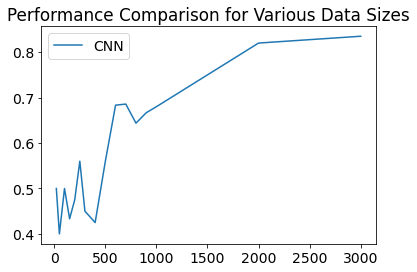

In [5]:
Ndat = [20,50,100,150,200,250,300,400,500,600,700,800,900,1000,2000,3000]
batch_sizes = [10,20,30,50,50,50,100,100,100,250,250,250,250,250,250,250]
CNN_acc = []

for i in range(len(Ndat)):
    N = Ndat[i]
    # resize data
    s_x_train = x_train[0:N,:]
    s_y_train = y_train[0:N]
    s_x_val = x_val[0:int(0.2*N),:]
    s_y_val = y_val[0:int(0.2*N)]
    
    #train and test CNN
    EPOCHS = 100 #needs tuned for comparison with XGBoost
    if i < 9:
        BATCH_SIZE =  batch_sizes[i] #not sure
    else: BATCH_SIZE = 250
    CNN = compile_CNN()
    fit = CNN.fit(s_x_train,s_y_train,batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(s_x_val, s_y_val),
                    verbose=0, shuffle=True,callbacks=[model_checkpoint_callback])
    maxAcc = np.max(fit.history['val_accuracy'])
    CNN_acc.append(maxAcc)


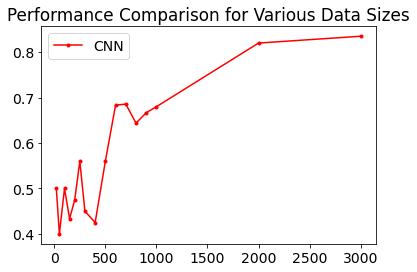

In [8]:
figDataSize = plt.figure()
plt.plot(Ndat,CNN_acc, 'r.-', label = 'CNN')
plt.title('Performance Comparison for Various Data Sizes')
plt.legend()

# XGBoost with tsfresh

In [ ]:

#turn data into a dataframe that is compatable with tsfresh
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t)
    #build time columns
    time_col = np.tile(np.arange(t),N)
    #build var columns
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

df = get_df(x)

#extract features
x_features = extract_features(
                            df, #our dataframe
                            column_id='id', #sample id, from 0 to N
                            column_sort='time', #timestep, from 0 to t
                            column_kind=None, #we have only one feature
                            column_value='value', #value of input 
                            n_jobs=4) #number of cores

#remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

#split data into training and validation

perc_train=0.8
N_train = int(perc_train*N)
x_train = x_features[:N_train]
y_train = y[:N_train]
x_val = x_features[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)

#rescale: in each feature, remove average and divide by std
average = np.mean(x_train,axis=0)
x_train -= average
x_val -= average

std = np.std(x_train,axis=0)
x_train /= std
x_val /= std

def XGB_compile():
    # reproducibility
    np.random.seed(12345)

    #define parameters for xgboost
    params = {'max_depth':6,'min_child_weight':1,\
              'learning_rate':0.3,'use_label_encoder':False}

    #build model with given params
    model = XGBClassifier(**params)
    return model
#fit
XGB = XGB_compile()
fit = XGB.fit(x_train.values,y_train)

ERROR! Session/line number was not unique in database. History logging moved to new session 378


Feature Extraction:   0%|                                | 0/20 [00:00<?, ?it/s]


In [ ]:
loss1, acc1 = model.evaluate(x=x_val, y=y_val, verbose = 0)